In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
import glob
from metpy.units import units
import metpy.calc as mpcalc
import act
from datetime import datetime, timedelta
import xarray as xr

In [9]:
files = glob.glob("../data/soundings/uiuc*/*RTS.txt")
files

['../data/soundings/uiuc-shedd/20240722_1730_Sonde1_RTS.txt',
 '../data/soundings/uiuc-shedd/20240723_1630_Sonde1_RTS.txt',
 '../data/soundings/uiuc-shedd/20240722_1600_Sonde1_RTS.txt',
 '../data/soundings/uiuc-shedd/20240723_1200_Sonde1_RTS.txt',
 '../data/soundings/uiuc-shedd/20240722_1200_Sonde1_RTS.txt',
 '../data/soundings/uiuc-shedd/20240723_0030_Sonde1_RTS.txt',
 '../data/soundings/uiuc-shedd/20240722_1900_Sonde1_RTS.txt',
 '../data/soundings/uiuc-comer/20240722_1831_Sonde3_RTS.txt',
 '../data/soundings/uiuc-comer/20240722_2105_Sonde3_RTS.txt',
 '../data/soundings/uiuc-comer/20240723_1200_Sonde3_RTS.txt',
 '../data/soundings/uiuc-comer/20240723_0030_Sonde3_RTS.txt',
 '../data/soundings/uiuc-comer/20240723_1805_Sonde3_RTS.txt',
 '../data/soundings/uiuc-comer/20240722_1531_Sonde3_RTS.txt',
 '../data/soundings/uiuc-comer/20240722_1700_Sonde3_RTS.txt']

In [15]:
from pathlib import Path 


'20240722_1700_comer'

In [17]:
for file in files:
    df = pd.read_fwf(file, delimiter='\t', encoding='iso-8859-1')
    print(df)

    path = Path(file)
    if "Sonde3" in file:
        out = str(path.stem.replace("Sonde3_RTS", "comer"))
    elif "Sonde1" in file:
        out = str(path.stem.replace("Sonde1_RTS", "shedd"))

    df.to_csv(f"{path.parent}/{out}.csv")
    

      Time[sec]  Pressure[mbar]  T[°C]   U[%]  Geo Pot[m]  Dew [°C]  RI      \
0           0.0           996.0    34.3    55         189    23.9     253.6   
1           1.0           995.9    34.1   ///         191   ///./     ///./   
2           2.0           995.9    33.8   ///         192   ///./     ///./   
3           3.0           995.8    33.6   ///         193   ///./     ///./   
4           4.0           995.7    33.3   ///         193   ///./     ///./   
...         ...             ...     ...   ...         ...       ...     ...   
3450     3450.0           256.4   -48.4   ///       10594   ///./     ///./   
3451     3451.0           256.3   -48.4   ///       10597   ///./     ///./   
3452     3452.0           256.2   -48.5   ///       10601   ///./     ///./   
3453     3453.0           256.1   -48.5   ///       10604   ///./     ///./   
3454     3454.0           255.9   -48.5   ///       10608   ///./     ///./   

      GRI       MRI      CL [m/s]  ...  Spec U [g/k

In [58]:
files = sorted(glob.glob("../data/soundings/uiuc*/*.csv"))
files

['../data/soundings/uiuc-comer/20240722_1531_comer.csv',
 '../data/soundings/uiuc-comer/20240722_1700_comer.csv',
 '../data/soundings/uiuc-comer/20240722_1831_comer.csv',
 '../data/soundings/uiuc-comer/20240722_2105_comer.csv',
 '../data/soundings/uiuc-comer/20240723_0030_comer.csv',
 '../data/soundings/uiuc-comer/20240723_1200_comer.csv',
 '../data/soundings/uiuc-comer/20240723_1805_comer.csv',
 '../data/soundings/uiuc-shedd/20240722_1200_shedd.csv',
 '../data/soundings/uiuc-shedd/20240722_1600_shedd.csv',
 '../data/soundings/uiuc-shedd/20240722_1730_shedd.csv',
 '../data/soundings/uiuc-shedd/20240722_1900_shedd.csv',
 '../data/soundings/uiuc-shedd/20240723_0030_shedd.csv',
 '../data/soundings/uiuc-shedd/20240723_1200_shedd.csv',
 '../data/soundings/uiuc-shedd/20240723_1630_shedd.csv']

In [59]:
df = pd.read_csv(files[0])

In [60]:
Path(file).stem[:13]

'20240723_1805'

In [61]:
comer_list = []
shedd_list = []
for file in files:

    df = pd.read_csv(file)
    
    p = df['Pressure[mbar]'].values * units.hPa
    z = df['Geometric Height [m]'].values * units.m
    T = df['T[°C] '].values * units.degC
    Td = df['Dew [°C]'].values * units.degC
    wind_speed = df['Wsp [m/s]'].values * units("m/s")
    wind_dir = df['Wdir [°]'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    df = df.drop_duplicates("Pressure[mbar]")

    ds = df.to_xarray()
    ds["alt"] = ds["Geometric Height [m]"] - ds["Geometric Height [m]"].values[0]
    ds = ds.swap_dims({"index":"time"})
    ds["T[°C] "].attrs["units"] = "degC"
    ds = ds.rename({"T[°C] ":"tdry"})
    ds["Wsp [m/s]"].attrs["units"] = "m/s"
    ds["Pressure[mbar]"].attrs["units"] = "hPa"
    ds["time"] = [datetime.strptime(Path(file).stem[:13], "%Y%m%d_%H%M") + timedelta(seconds=int(s)) for s in list(ds.time.values)]

    ds.resample(time="1min").mean()

    try:
        ds = act.retrievals.calculate_pbl_liu_liang(ds,
                                                pressure="Pressure[mbar]",
                                                windspeed="Wsp [m/s]",
                                                height="alt")
        ds = ds.drop_duplicates("atm_pres_ss")
    except:
        pass
    ds = ds.expand_dims("launch_time")
    ds["launch_time"] = [ds.time.isel(time=0).values]

    if "comer" in file:
        comer_list.append(ds)
    elif "shedd" in file:
        shedd_list.append(ds)

/Users/mgrover/mambaforge/envs/ingests-dev/lib/python3.11/site-packages/act/retrievals/sonde.py:290: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/mgrover/mambaforge/envs/ingests-dev/lib/python3.11/site-packages/act/retrievals/sonde.py:300: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/mgrover/mambaforge/envs/ingests-dev/lib/python3.11/site-packages/act/retrievals/sonde.py:290: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt)
/Users/mgrover/mambaforge/envs/ingests-dev/lib/python3.11/site-packages/act/retrievals/sonde.py:300: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np.diff(theta) / np.diff(alt / 1000.0)
/Users/mgrover/mambaforge/envs/ingests-dev/lib/python3.11/site-packages/act/retrievals/sonde.py:290: RuntimeWarning: invalid value encountered in divide
  theta_gradient = np

In [64]:
humboldt_ds = xr.open_dataset("khum-soundings-with-pbl.nc")

In [62]:
comer_ds = xr.concat(comer_list, dim='launch_time', coords='minimal', compat="override")
shedd_ds =  xr.concat(shedd_list, dim='launch_time', coords='minimal', compat="override")

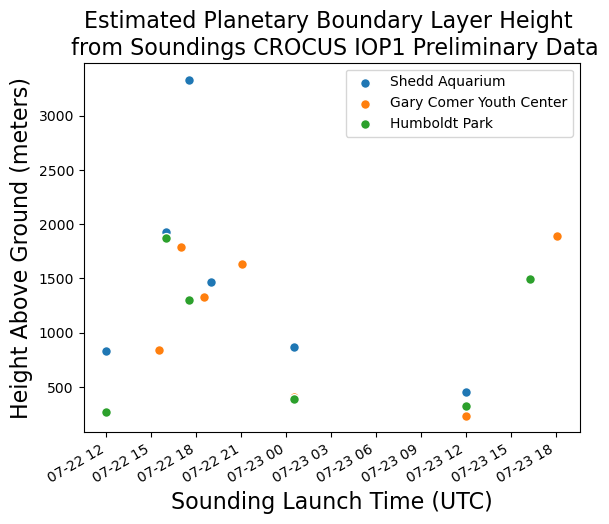

In [78]:
shedd_ds.pblht_liu_liang.plot.scatter(s=50, label='Shedd Aquarium')
comer_ds.pblht_liu_liang.plot.scatter(s=50, label='Gary Comer Youth Center')
humboldt_ds.pblht_liu_liang.plot.scatter(s=50, label='Humboldt Park')
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (meters)", fontsize=16)
plt.xlabel("Sounding Launch Time (UTC)", fontsize=16)
plt.title("Estimated Planetary Boundary Layer Height \n from Soundings CROCUS IOP1 Preliminary Data", fontsize=16)
plt.savefig("pbl-height-iop1.png", dpi=300)